# Word2Vec : hands-on Python

Requirements: install packages `sklearn`, `nltk` and `gensim` (for Word2Vec). Gensim is available here: https://radimrehurek.com/gensim/install.html.

In [1]:
import gzip 
import nltk
import json
import os
from tqdm.notebook import tqdm   # progress bar

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Upload data and process 

In [2]:
data_path = "./crime_and_punishment.txt"

##  Split text into sentences 

In [3]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

all_sentences = []
with open(data_path, "r", encoding = "utf-8") as fp:
    text = fp.read()
    text = text.replace("\n\n", " ") 
    all_sentences = sent_detector.tokenize(text.strip())   # nltk feels to be better in detecing sentences, bu
print(len(all_sentences))

12067


Compare using `spacy` and `nltk` "out-of-the-box" in this task.

In [4]:
import spacy
import en_core_web_md
spacy_model = en_core_web_md.load()

In [6]:
# CHUNK OF TEXT TO USE
chunk_text = text[8000:9597]
print(chunk_text) 

I going there now? Am I capable of that? Is that serious? It is not serious at all. It’s simply a fantasy to amuse myself; a plaything! Yes, maybe it is a plaything.” The heat in the street was terrible: and the airlessness, the bustle and the plaster, scaffolding, bricks, and dust all about him, and that special Petersburg stench, so familiar to all who are unable to get out of town in summer—all worked painfully upon the young man’s already overwrought nerves. The insufferable stench from the pot-houses, which are particularly numerous in that part of the town, and the drunken men whom he met continually, although it was a working day, completed the revolting misery of the picture. An expression of the profoundest disgust gleamed for a moment in the young man’s refined face. He was, by the way, exceptionally handsome, above the average in height, slim, well-built, with beautiful dark eyes and dark brown hair. Soon he sank into deep thought, or more accurately speaking into a complete

In [7]:
# SPACY MODEL
tdoc = spacy_model(chunk_text)
sents = list(tdoc.sents)
sents

[I going there now?,
 Am I capable of that?,
 Is that serious?,
 It is not serious at all.,
 It’s simply a fantasy to amuse myself; a plaything!,
 Yes, maybe it is a plaything.,
 ”,
 The heat in the street was terrible: and the airlessness, the bustle and the plaster, scaffolding, bricks, and dust all about him, and that special Petersburg stench, so familiar to all who are unable to get out of town in summer—all worked painfully upon the young man,
 ’s already overwrought nerves.,
 The insufferable stench from the pot-houses, which are particularly numerous in that part of the town, and the drunken men whom he met continually, although it was a working day, completed the revolting misery of the picture.,
 An expression of the profoundest disgust gleamed for a moment in the young man,
 ’s refined face.,
 He was, by the way, exceptionally handsome, above the average in height, slim, well-built, with beautiful dark eyes and dark brown hair.,
 Soon he sank into deep thought, or more accur

In [8]:
# NLTK MODEL
nltk_sents = sent_detector.tokenize(chunk_text)
nltk_sents

['I going there now?',
 'Am I capable of that?',
 'Is that serious?',
 'It is not serious at all.',
 'It’s simply a fantasy to amuse myself; a plaything!',
 'Yes, maybe it is a plaything.” The heat in the street was terrible: and the airlessness, the bustle and the plaster, scaffolding, bricks, and dust all about him, and that special Petersburg stench, so familiar to all who are unable to get out of town in summer—all worked painfully upon the young man’s already overwrought nerves.',
 'The insufferable stench from the pot-houses, which are particularly numerous in that part of the town, and the drunken men whom he met continually, although it was a working day, completed the revolting misery of the picture.',
 'An expression of the profoundest disgust gleamed for a moment in the young man’s refined face.',
 'He was, by the way, exceptionally handsome, above the average in height, slim, well-built, with beautiful dark eyes and dark brown hair.',
 'Soon he sank into deep thought, or mo

# Named Entity Recognition

First we would like to identify all persons in the text. For the sake of providing an example, we will work only with the output of the module `spacy`.

### Single sentence

Example with one sentence

In [9]:
sent = all_sentences[13]
print(sent)

After eight months’ imprisonment he was with twenty-one others taken out to the Semyonovsky Square to be shot.


In [10]:
doc = spacy_model(sent)
# PRINT LABELS OF THE INFERRED TEXT
print(f"Entities: {[(X.text, X.label_) for X in doc.ents]}")

# PRINT THE POSITIONS OF THE NAMED ENTITIES
print(f"Positions: {[(e.start, e.end) for e in doc.ents]}")

Entities: [('eight months', 'DATE'), ('twenty-one', 'CARDINAL'), ('the Semyonovsky Square', 'FAC')]
Positions: [(1, 3), (8, 11), (15, 18)]


In [11]:
[t.text for t in doc]

['After',
 'eight',
 'months',
 '’',
 'imprisonment',
 'he',
 'was',
 'with',
 'twenty',
 '-',
 'one',
 'others',
 'taken',
 'out',
 'to',
 'the',
 'Semyonovsky',
 'Square',
 'to',
 'be',
 'shot',
 '.']

In [12]:
# UNDERSCORE THE COMPOUND ENTITIES
sent_modified = sent
doc = spacy_model(sent_modified)
for entity in doc.ents:
    entity_list = entity.text.split()
    if len(entity_list) > 1:
        entity_underscored = "_".join(entity_list)
        i_begin = sent.index(entity.text)
        sent_modified = sent_modified.replace(entity.text, entity_underscored)
print(sent_modified)

After eight_months’ imprisonment he was with twenty-one others taken out to the_Semyonovsky_Square to be shot.


In [13]:
import string
def delete_punctuation(sent):
    sent = sent.replace("“", "") # Weird character
    sent = sent.replace("’s", "") # Weird character 2
#     sent = sent.replace("’", "") # Weird character 3
    sent = sent.replace("”", "") # Weird character 4
    sent = sent.replace("‘", "") # Weird character 5
#     words = sent.split()
#     table = str.maketrans('', '', string.punctuation)
#     stripped = [w.translate(table) for w in words]
#     sent_clean = " ".join(stripped)
    return sent 

sent = all_sentences[130]
print(delete_punctuation(sent))

I’ve brought something to pawn here, and he drew out of his pocket an old-fashioned flat silver watch, on the back of which was engraved a globe; the chain was of steel.


In [14]:
from collections import defaultdict
person_set = set([])
person_dict = defaultdict(int)
location_set = set([])

all_sentences_clean = []
for sent in tqdm(all_sentences):
    sent_clean = delete_punctuation(sent)
    doc = spacy_model(sent_clean)
    for X in doc.ents:
        if X.label_ == "PERSON":
            person_dict[X.text] += 1
            person_set.add(X.text)
        if X.label_ == "LOC":
            location_set.add(X.text)
    all_sentences_clean.append(sent_clean)
print(f"FOUND: Persons :: {len(person_set)}, Locations :: {len(location_set)}")


FOUND: Persons :: 253, Locations :: 13


In [16]:
del person_dict["’m"]
del person_dict["’d"]
del person_dict["Project Gutenberg-tm"]
del person_dict["Project Gutenberg"]

In [17]:
person_list = sorted(list(person_dict.items()), key = lambda x: x[1], reverse = True) 
person_list_trunc = person_list[:100]
for p, c in person_list_trunc:
#     if len(p.split()) > 1:
    print(p, c)

Raskolnikov 742
Sonia 398
Katerina Ivanovna 214
Rodya 124
Pulcheria Alexandrovna 121
Avdotya Romanovna 114
Luzhin 82
Zametov 82
Rodion Romanovitch 82
Svidrigaïlov 76
Marfa Petrovna 74
Zossimov 72
Lebeziatnikov 71
Sofya Semyonovna 69
Porfiry Petrovitch 64
Razumihin 53
Amalia Ivanovna 50
Nastasya 48
Porfiry 39
Ilya Petrovitch 33
Dmitri 25
Nikodim Fomitch 24
Dmitri Prokofitch 23
Lizaveta 22
Koch 20
Marmeladov 18
Lida 17
Kolya 16
Andrey Semyonovitch 16
Alyona Ivanovna 15
Polenka 15
Nikolay 13
Dounia 12
Mikolka 12
Jesus 11
Pestryakov 10
Dostoevsky 9
Neva 9
Semyon Zaharovitch 9
Praskovya Pavlovna 9
Luise Ivanovna 8
Captain 8
Amalia Ludwigovna 8
Madame Resslich 8
Napoleon 7
Tchebarov 6
Karl 6
Dushkin 6
Arkady Ivanovitch 6
Philip 6
Lazarus 6
Katia 6
Lizaveta Ivanovna 5
Pashenka 5
Bakaleyev 5
Andrey Semyonovitch Lebeziatnikov 5
Madame Lippevechsel 5
Potchinkov 5
Rodion 5
Pyotr Petrovitch 5
Martha 5
Gogol 4
Pushkin 4
Kapernaumovs 4
Kapernaumov 4
Svidrigaïlovs 4
Pyotr Petrovitch Luzhin 4
Vassilye

In [221]:
# RIGHT WAY TO GO - CREATE THE DICTIONARY OF ALL POSSIBLE MENTIONS OF A CHARACTER
manual_character_list = {
    "Rodion Raskolnikov" : ["Rodion Romanovich Raskolnikov", "Rodya", "Rodka", "Rodion Romanovich", 
                                       "Rodion", "Raskolnikov"],
    "Sofya Marmeladov": ["Sofya Semyonovna Marmeladov", "Sofya Semyonovna", "Sonia", "Sonya", "Sonechka" ]
    "..." : ["..."]
}

SyntaxError: invalid syntax (<ipython-input-221-937aeef5c12d>, line 6)

In [18]:
# LAZY WAY TO GO - JUST SUBSTITUTE THE COMPOUND NAMES
persons_list = sorted(list(person_dict.items()), key = lambda x: x[1], reverse = True) 
persons_list = persons_list[:100]

compound_person_dict = defaultdict()
for person, count in persons_list:
    person_list = person.split()
    if len(person_list)>1:
        compound_person_dict[person] = "_".join(person_list)
    else:
        compound_person_dict[person] = person

all_sentences_clean2 = []
for sent in tqdm(all_sentences_clean):
    sent_clean = sent
    for person, compound_person in compound_person_dict.items():
        sent_clean = sent_clean.replace(person, compound_person)
    all_sentences_clean2.append(sent_clean)

In [19]:
all_sentences_clean2[155:160]

['You are too quick.... Good-day, Alyona_Ivanovna. Raskolnikov went out in complete confusion.',
 'This confusion became more and more intense.',
 'As he went down the stairs, he even stopped short, two or three times, as though suddenly struck by some thought.',
 'When he was in the street he cried out, Oh, God, how loathsome it all is!',
 'and can I, can I possibly.... No, it nonsense, it rubbish! he added resolutely.']

In [21]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags       # strip html tags
from gensim.parsing.preprocessing import strip_short      
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_punctuation, strip_non_alphanum

# select the filters you wish to apply here
CUSTOM_FILTERS = [lambda x: x.lower(), strip_non_alphanum, remove_stopwords, strip_multiple_whitespaces]

all_sentences_preprocessed = []
for sent in tqdm(all_sentences_clean2):
    parsed_line = preprocess_string(sent, CUSTOM_FILTERS)
    all_sentences_preprocessed.append(parsed_line)
    
print(len(all_sentences_preprocessed))


12067


# Train Word2Vec 

We use the module `gensim` with already prepared Word2Vec model training. We will train the word embeddings using the corpus of the F.Dostoevsky's story "Crime and Punishment".

In [22]:
all_sentences_preprocessed[0]

['project',
 'gutenberg',
 'ebook',
 'crime',
 'punishment',
 'fyodor_dostoevsky',
 'ebook',
 'use',
 'cost',
 'restrictions',
 'whatsoever']

In [45]:
import gensim

# DEFINE MODEL
model = gensim.models.Word2Vec(size=100, window = 4,
                               min_count=10, alpha = 0.01)

# BUILD VOCABULARY
model.build_vocab(all_sentences_preprocessed)

# AND TRAIN THE MODEL
iterations = tqdm(range(10))
for i in iterations:
    model.train(all_sentences_preprocessed, total_examples=model.corpus_count, compute_loss = True, 
                epochs = 100)
    msg = f"Iter :: {i} -- Loss :: {model.get_latest_training_loss()}"
    iterations.set_postfix_str(s = msg, refresh=True)

# GET THE VOCABULARY FROM THE MODEL
vocabulary = list(model.wv.vocab)
print(f"Vocabulary size :: {len(vocabulary)}")

# GET THE WORD EMBEDDING VECTORS
embedding_vectors = model[model.wv.vocab]


Vocabulary size :: 1585


In [24]:
# GET THE LOWER CASE REPRESENTATION OF NAMED ENTITIES THAT ARE IN THE VOCABULARY
person_set_processed = [s for s in compound_person_dict.values() if s.lower() in vocabulary]
person_set_vocab = [s.lower() for s in person_set_processed]
len(person_set_vocab)

47

# Plot the results
 
To plot the embedding we need to project the vectors from 300D to 2D. For this purpose you may use any dimensionality reduction algorithm you want. Here I present the module `scikit-learn` which contains implemented algorithms for this and many other purposes.

In [25]:
embedding_vectors[0]

array([-2.317335  ,  1.9815003 ,  5.213613  ,  2.1756704 ,  4.8830557 ,
        1.8681598 , -1.7499969 ,  3.5835404 , -2.4135509 ,  1.5349731 ,
        2.6875393 , -0.40658048, -1.9547362 , -4.755799  , -1.4933424 ,
       -1.3995574 , -0.9606329 ,  0.33070427,  8.661038  , -0.8189769 ,
       -0.957863  ,  1.4074526 , -0.80234814, -0.8493397 , -3.512101  ,
        5.1066256 ,  1.241119  , -0.6361922 , -2.6733665 ,  5.501216  ,
       -0.23108046, -2.090601  , -2.9409256 , -3.6920934 , -4.882481  ,
        0.7843278 ,  2.1897783 , -1.0453988 ,  4.902875  , -1.6031666 ,
        3.7942245 ,  0.7506788 ,  1.5121189 ,  2.7350793 ,  2.6505022 ,
        4.240297  ,  5.8224206 ,  2.3971357 ,  1.032673  , -2.22508   ,
       -2.5459907 , -2.9040434 , -0.7557103 , -0.1818227 , -2.1170435 ,
        2.3560913 ,  0.39183915, -1.8693191 ,  1.9871261 ,  0.05475682,
        2.2788925 , -5.6341577 ,  1.1851426 ,  3.2919805 , -1.8343314 ,
        2.5563464 ,  0.15023158, -2.4383497 ,  4.2698975 , -4.10

In [46]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# TRANSFORM THE EMBEDDING USING T-SNE INTO 2D
V_tranform = TSNE(n_components=2).fit_transform(embedding_vectors)

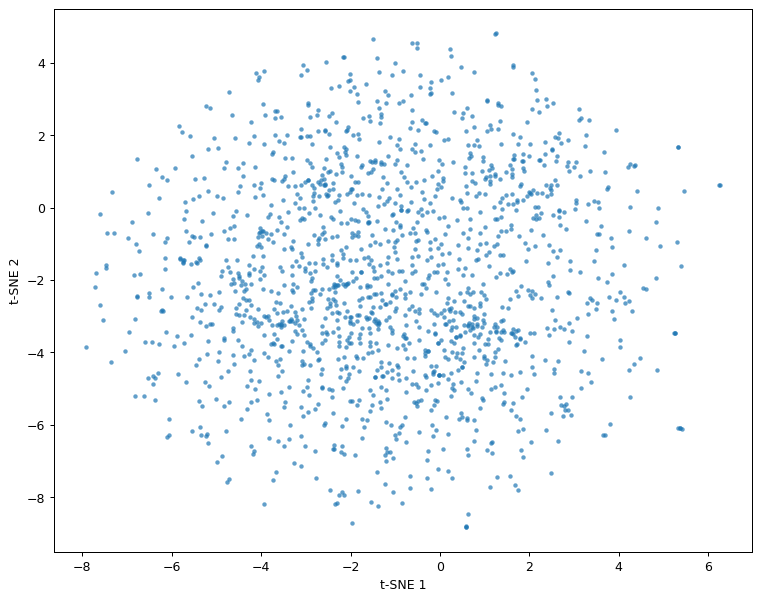

In [27]:
# PLOT THE PROJECTION
fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*V_tranform), marker='.', s=50, lw=0, alpha=0.7, 
                 edgecolor='k')
# for i, (x,y) in enumerate(V_tranform):
#     plt.text(x,y, vocabulary[i], 
#                 fontsize = 4, alpha = 0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

Now we use a clustering algorithm from the same module. Check out the documentation to see which clustering algorithms are available https://scikit-learn.org/stable/modules/clustering.html. 

For example, we will use here the k-means clustering. For that algorithm we have to specify the desired number of clusters we wish to obtain.

**ADDENDUM**

Be careful: kmeans is distance based (a cluster = a set of close points in space). When using kmeans with text, you should use the **cosine distance** on the original embedding vectors. Then you will get the real clustering of the data.

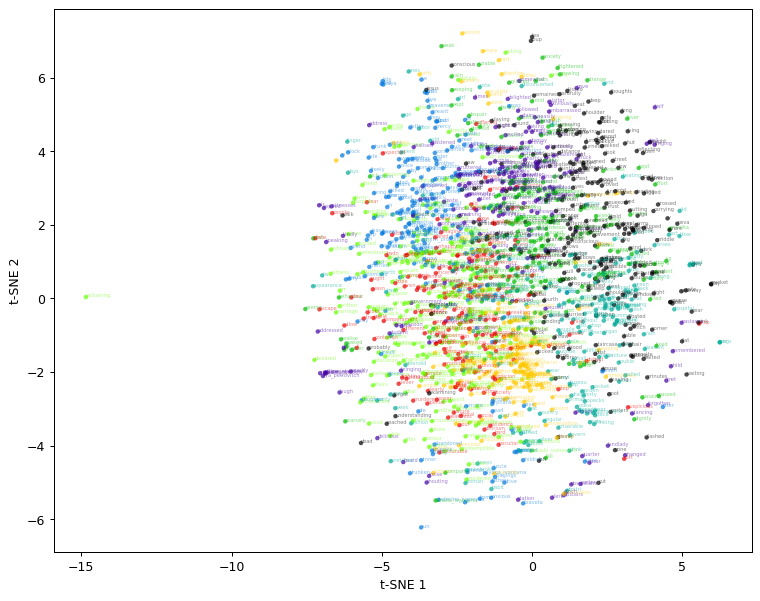

In [48]:
# THIS IS THE IMPLEMENTATION OF THE KMEANS WITH COSINE DISTANCE
from nltk.cluster import KMeansClusterer

# desired number of clusters to find
NUM_CLUSTERS=8

# Sparial clustering with k-means

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance= nltk.cluster.util.cosine_distance, repeats=10)

# be careful to supply the original vectors to the algorithm!
assigned_clusters = kclusterer.cluster(embedding_vectors, assign_clusters=True)

# DEFINE COLORS OF CLUSTERS 
colors = cm.nipy_spectral(np.array(assigned_clusters).astype(float) / NUM_CLUSTERS)

# PLOT THE RESULTS
fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*V_tranform), marker='.', s=50, lw=0, alpha=0.7, c=colors,
                 edgecolor='k')

for i, (x,y) in enumerate(V_tranform):
    plt.text(x,y, vocabulary[i], color = colors[i], 
                fontsize = 4, alpha = 0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

However `scikit-learn` has only Euclidean distance based kmeans clustering. You can use it for visual presentation of the results. Here you supply the projected data into 2D.

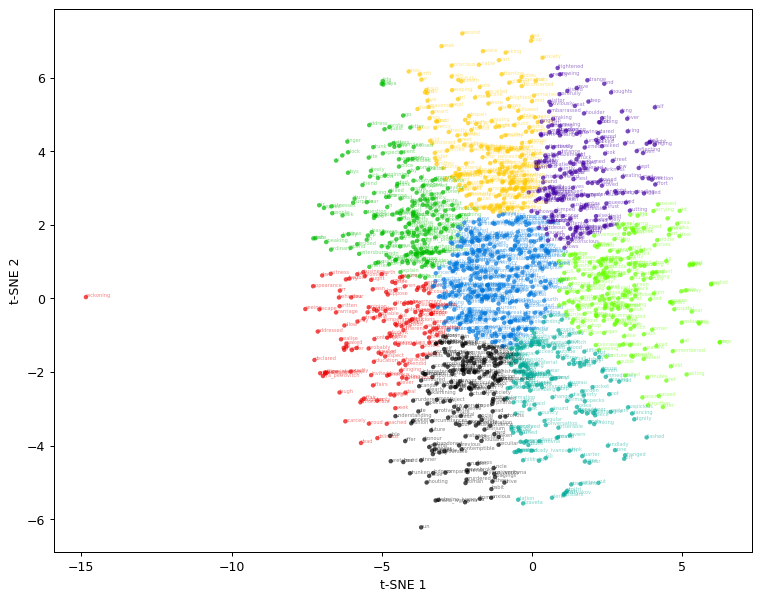

In [50]:
# THIS IS THE IMPLEMENTATION OF THE KMEANS WITH EUCLIDEAN DISTANCE
from sklearn.cluster import KMeans

# desired number of clusters to find
NUM_CLUSTERS=8

# Sparial clustering with k-means

kclusterer_sklearn = KMeans(n_clusters = NUM_CLUSTERS)

# be careful to supply the projected vectors (2D) to the algorithm!
assigned_clusters = kclusterer_sklearn.fit_predict(V_tranform)

# DEFINE COLORS OF CLUSTERS 
colors = cm.nipy_spectral(np.array(assigned_clusters).astype(float) / NUM_CLUSTERS)

# PLOT THE RESULTS
fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*V_tranform), marker='.', s=50, lw=0, alpha=0.7, c=colors,
                 edgecolor='k')

for i, (x,y) in enumerate(V_tranform):
    plt.text(x,y, vocabulary[i], color = colors[i], 
                fontsize = 4, alpha = 0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

#### ONLY CHARACTERS (SUBSET OF WORDS) 

If we want to project only a subset of characters, then we have to use only a subset of vectors.

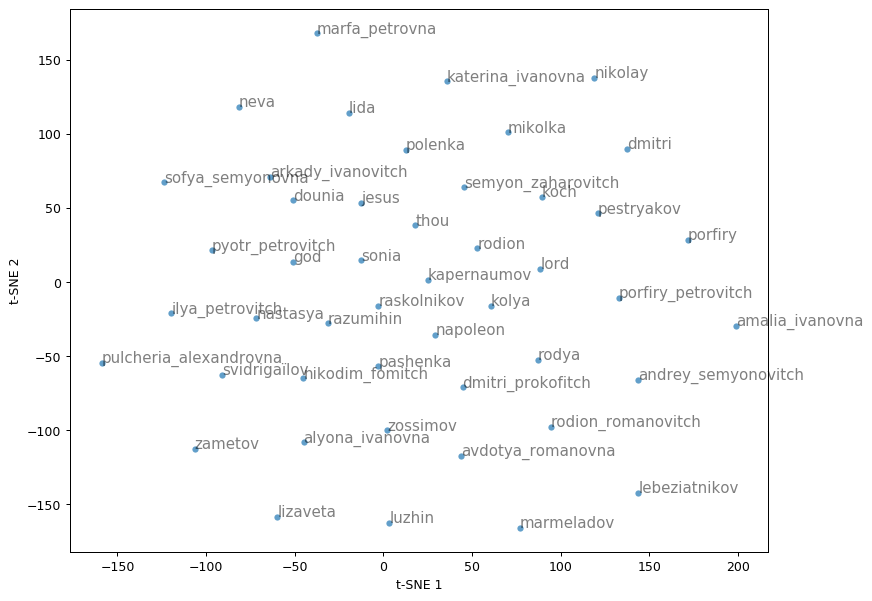

In [51]:
# GET SUBSET OF VECTORS
person_embedding_vectors = model[person_set_vocab]

# PROJECT IT INTO 2D
V_tranform = TSNE(n_components=2).fit_transform(person_embedding_vectors)

# PLOT THE PROJECTION
fig = plt.figure(figsize = (10,8), dpi = 90)
plt.scatter(*zip(*V_tranform), marker='.', s=100, lw=0, alpha=0.7, 
                 edgecolor='k')
for i, (x,y) in enumerate(V_tranform):
    plt.text(x,y, person_set_vocab[i], 
                fontsize = 12, alpha = 0.5)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

## Other features 

Please check the documentation of `gensim` and `scikit-learn` to know more about cool algorithms and features implemented there.

In [31]:
word = "raskolnikov"
similar_words = sorted(model.wv.most_similar(positive=[word], topn = 10), key = lambda x: x[1], reverse = False)

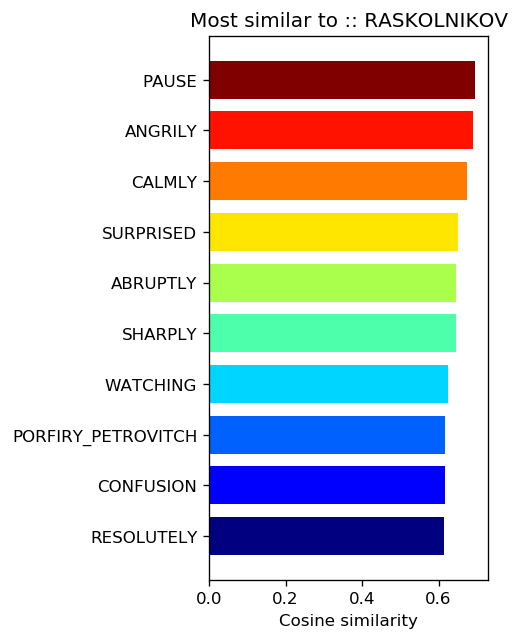

In [32]:
X, Y = zip(*similar_words)
X = [x.upper() for x in X]
colors = plt.cm.jet(np.linspace(0,1,len(X)))
fig = plt.figure(figsize = (3,6), dpi = 120)
plt.title(f"Most similar to :: {word.upper()}")
plt.barh(X, Y, align='center', height=0.75, color = colors)
plt.xlabel("Cosine similarity")
plt.show()

# Train Doc2Vec on the set of sentences

There is a useful extension for training Word2Vec on the set of full sentences - Doc2Vec. When W2V learns vectors only for words, D2V learns vectors also for sentences. 

In [33]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

X_train = all_sentences_preprocessed[:100]
X_test = all_sentences_preprocessed[100:110]

# PREPARE THE SET OF DOCUMENTS FOR THE MODEL
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train)]

In [37]:
documents[2]

TaggedDocument(words=['dostoevsky', 'son', 'doctor'], tags=[2])

In [34]:
# DEFINE MODEL
doc_model = gensim.models.Doc2Vec(vector_size=300, window=4,  compute_loss = True,
                               min_count=5, alpha = 0.01)

# BUILD VOCABULARY
doc_model.build_vocab(documents)

# AND TRAIN THE MODEL
iterations = tqdm(range(10))
for i in iterations:
    doc_model.train(documents, total_examples=doc_model.corpus_count,
                epochs = 100)
    msg = f"Iter :: {i}"
    iterations.set_postfix_str(s = msg, refresh=True)

In [38]:
# GET THE EXISTING DOC VECTOR
dv = doc_model.docvecs[2]
dv[:20]

array([ 0.01036822,  0.04650604,  0.03160207, -0.03698659, -0.04000721,
        0.0128273 ,  0.01332922, -0.01452308,  0.01004345, -0.02380184,
        0.05265097, -0.01444963, -0.01634987,  0.01226435,  0.01133563,
        0.04265833, -0.05191705,  0.01566068, -0.03672237, -0.02445091],
      dtype=float32)

In [42]:
# INFER THE DOC VECTOR FOR THE NEW DOCUMENT
inferred_dv = doc_model.infer_vector(X_test[0], min_alpha = 1e-16, epochs = 5000)
inferred_dv[:20]

array([ 4.4489381e-04,  1.3757953e-03,  1.4409040e-03,  1.0516263e-03,
        6.9835442e-05,  3.6621877e-04,  8.0237602e-04, -1.6007199e-03,
       -6.7969857e-05, -8.7884546e-04, -1.3047098e-03,  1.0768810e-03,
       -5.6750950e-04,  9.5600226e-05,  4.0879656e-04,  6.8759348e-04,
       -8.4579340e-05, -7.8543417e-05, -4.7645150e-04,  1.0647963e-03],
      dtype=float32)